<a href="https://colab.research.google.com/github/shailavij/NLP/blob/master/Fake_News_Detection_LSTM_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Fake News Detection using LSTM_Tensorflow
# Import packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from wordcloud import WordCloud

In [2]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,Dropout,Embedding,Conv1D,MaxPool1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score

In [3]:
# Import CSV files
fake= pd.read_csv('https://raw.githubusercontent.com/laxmimerit/fake-real-news-dataset/main/data/Fake.csv')

In [4]:
fake.head(10)

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"
5,Racist Alabama Cops Brutalize Black Boy While...,The number of cases of cops brutalizing and ki...,News,"December 25, 2017"
6,"Fresh Off The Golf Course, Trump Lashes Out A...",Donald Trump spent a good portion of his day a...,News,"December 23, 2017"
7,Trump Said Some INSANELY Racist Stuff Inside ...,In the wake of yet another court decision that...,News,"December 23, 2017"
8,Former CIA Director Slams Trump Over UN Bully...,Many people have raised the alarm regarding th...,News,"December 22, 2017"
9,WATCH: Brand-New Pro-Trump Ad Features So Muc...,Just when you might have thought we d get a br...,News,"December 21, 2017"


In [5]:
fake.columns

Index(['title', 'text', 'subject', 'date'], dtype='object')

In [6]:
# Explore type of Subjects
fake['subject'].value_counts()

News               9050
politics           6841
left-news          4459
Government News    1570
US_News             783
Middle-east         778
Name: subject, dtype: int64

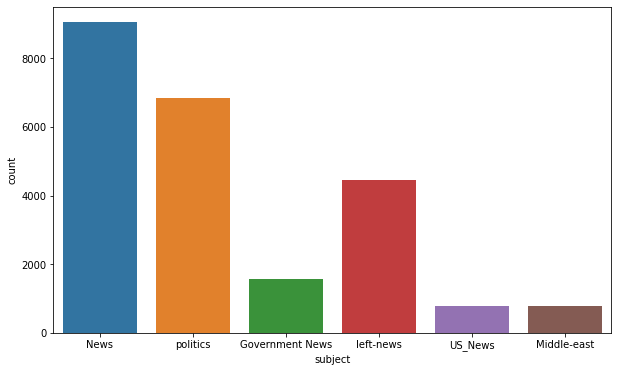

In [7]:
plt.figure(figsize=(10,6))
sns.countplot(x='subject',data=fake)

Wordcloud Analysis

In [8]:
text= ' '.join(fake['text'].tolist())

In [9]:
type(text)

str

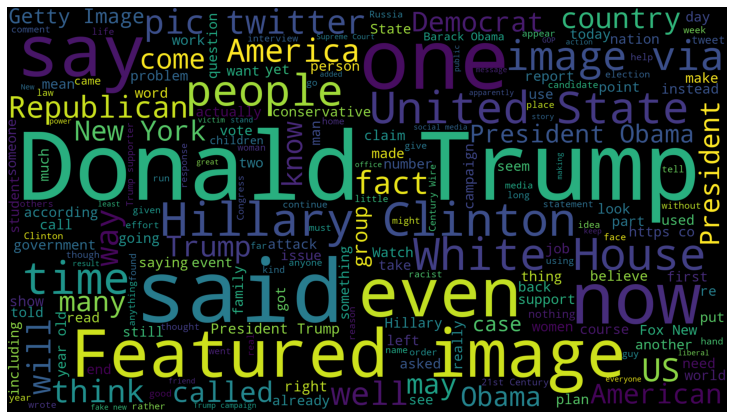

In [10]:
wordcloud = WordCloud(height= 1080  ,width= 1920 ).generate(text)
fig=plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [11]:
# Exploring Real News

real = pd.read_csv('https://raw.githubusercontent.com/laxmimerit/fake-real-news-dataset/main/data/True.csv')


In [12]:
real.shape

(21417, 4)

In [13]:
real.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [14]:
text1= ' '.join(real['text'].tolist())

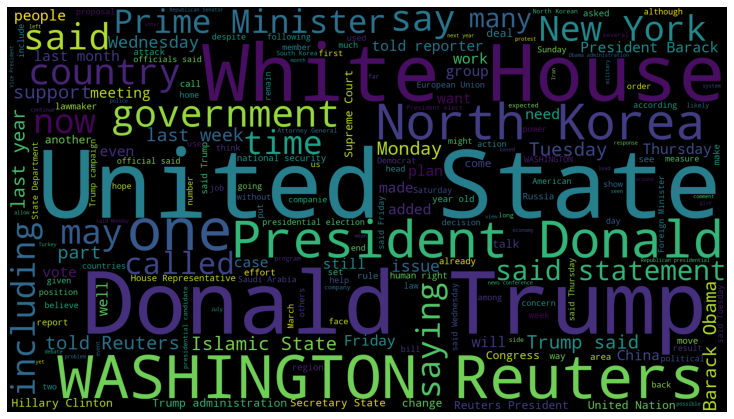

In [15]:
wordcloud = WordCloud(height= 1080  ,width= 1920 ).generate(text1)
fig=plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

# Difference in Real & Fake news

Real news seems to have Source of publication like 'Washington Reuter' which is not present in Fake news

Preprocessing of data

-> Removing Reuter or twitter tweet information from the text

*   Text can be splitted only once at '-' which is always present after publication . This give as publication part and text part
*   If we don't get text part means that publication detail was not given for that record. Twitter tweet will always have some source, a long text max of 259 character








In [16]:
# To get random 5 rows
real.sample(5)

,title,text,subject,date
3640,Flynn declines Senate subpoena in Russia probe,WASHINGTON (Reuters) - Former White House nati...,politicsNews,"May 22, 2017"
17158,Bosnia's Serb region declares neutrality in bi...,"BANJA LUKA, Bosnia (Reuters) - Bosnia s Serb R...",worldnews,"October 18, 2017"
16070,New Zealand PM says ban on foreign home buyers...,WELLINGTON (Reuters) - New Zealand Prime Minis...,worldnews,"October 31, 2017"
1169,Republican Thune says bipartisan U.S. health b...,WASHINGTON (Reuters) - U.S. Senator John Thune...,politicsNews,"October 18, 2017"
19076,Hopes and frustrations as Brexit talks resume ...,BRUSSELS (Reuters) - British and EU negotiator...,worldnews,"September 24, 2017"


In [17]:
unknown_publisher=[]

for index,text in enumerate(real.text.values):
  try:
    record=text.split('-', maxsplit=1)
    record[1]
    assert(len(record[0])<120)
  except:
    unknown_publisher.append(index)

In [18]:
len(unknown_publisher)

222

In [19]:
real.text.tolist()

['WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal conservative” on Sunday and urged budget restraint in 2018. In keeping with a sharp pivot under way among Republicans, U.S. Representative Mark Meadows, speaking on CBS’ “Face the Nation,” drew a hard line on federal spending, which lawmakers are bracing to do battle over in January. When they return from the holidays on Wednesday, lawmakers will begin trying to pass a federal budget in a fight likely to be linked to other issues, such as immigration policy, even as the November congressional election campaigns approach in which Republicans will seek to keep control of Congress. President Donald Trump and his Republicans want a big budget increase in military spending, while Democrats also want proportional increases for non-defense “discretionary” spending on programs that support educa

In [20]:
# Check for empty text in TExt column in Real data
[index for index, text in enumerate(real.text.tolist()) if str(text).strip()== ""  ]

[8970]

In [21]:
real.iloc[unknown_publisher].text

7        The following statements were posted to the ve...
8        The following statements were posted to the ve...
12       The following statements were posted to the ve...
13       The following statements were posted to the ve...
14        (In Dec. 25 story, in second paragraph, corre...
                               ...                        
20135     (Story corrects to million from billion in pa...
20500     (This Sept 8 story corrects headline, clarifi...
20667     (Story refiles to add dropped word  not , in ...
21246     (Story corrects third paragraph to show Mosul...
21339     (Story corrects to fix spelling in paragraph ...
Name: text, Length: 222, dtype: object

In [22]:
# Row.no .8970 is empty & doesn't have any text data. So we will drop that row
real.iloc[8970]

title      Graphic: Supreme Court roundup
text                                     
subject                      politicsNews
date                       June 16, 2016 
Name: 8970, dtype: object

In [23]:
real.drop(8970,axis=0,inplace=True)


In [24]:
# To split only data related to publisher information
publisher= []
temp_text=[]

for index,row in enumerate(real.text.values):
  if index in unknown_publisher:
    temp_text.append(row)
    publisher.append('Unknown')
  
  else:
    record = row.split('-' , maxsplit=1)
    publisher.append(record[0].strip())
    temp_text.append(record[1].strip())



In [25]:
real['publisher']=publisher
real['text']= temp_text
real.head(10)


,title,text,subject,date,publisher
0,"As U.S. budget fight looms, Republicans flip t...",The head of a conservative Republican faction ...,politicsNews,"December 31, 2017",WASHINGTON (Reuters)
1,U.S. military to accept transgender recruits o...,Transgender people will be allowed for the fir...,politicsNews,"December 29, 2017",WASHINGTON (Reuters)
2,Senior U.S. Republican senator: 'Let Mr. Muell...,The special counsel investigation of links bet...,politicsNews,"December 31, 2017",WASHINGTON (Reuters)
3,FBI Russia probe helped by Australian diplomat...,Trump campaign adviser George Papadopoulos tol...,politicsNews,"December 30, 2017",WASHINGTON (Reuters)
4,Trump wants Postal Service to charge 'much mor...,President Donald Trump called on the U.S. Post...,politicsNews,"December 29, 2017",SEATTLE/WASHINGTON (Reuters)
5,"White House, Congress prepare for talks on spe...",The White House said on Friday it was set to k...,politicsNews,"December 29, 2017","WEST PALM BEACH, Fla./WASHINGTON (Reuters)"
6,"Trump says Russia probe will be fair, but time...",President Donald Trump said on Thursday he bel...,politicsNews,"December 29, 2017","WEST PALM BEACH, Fla (Reuters)"
7,Factbox: Trump on Twitter (Dec 29) - Approval ...,The following statements were posted to the ve...,politicsNews,"December 29, 2017",Unknown
8,Trump on Twitter (Dec 28) - Global Warming,The following statements were posted to the ve...,politicsNews,"December 29, 2017",Unknown
9,Alabama official to certify Senator-elect Jone...,Alabama Secretary of State John Merrill said h...,politicsNews,"December 28, 2017",WASHINGTON (Reuters)


In [26]:
real.shape

(21416, 5)

In [27]:
# Check for empty text in TExt column in fake data
empty_fake_index= [index for index, text in enumerate(fake.text.tolist()) if str(text).strip()== ""  ]

In [28]:
fake.iloc[empty_fake_index]

,title,text,subject,date
10923,TAKE OUR POLL: Who Do You Think President Trum...,,politics,"May 10, 2017"
11041,Joe Scarborough BERATES Mika Brzezinski Over “...,,politics,"Apr 26, 2017"
11190,WATCH TUCKER CARLSON Scorch Sanctuary City May...,,politics,"Apr 6, 2017"
11225,MAYOR OF SANCTUARY CITY: Trump Trying To Make ...,,politics,"Apr 2, 2017"
11236,SHOCKER: Public School Turns Computer Lab Into...,,politics,"Apr 1, 2017"
...,...,...,...,...
21816,BALTIMORE BURNS: MARYLAND GOVERNOR BRINGS IN N...,,left-news,"Apr 27, 2015"
21826,FULL VIDEO: THE BLOCKBUSTER INVESTIGATION INTO...,,left-news,"Apr 25, 2015"
21827,(VIDEO) HILLARY CLINTON: RELIGIOUS BELIEFS MUS...,,left-news,"Apr 25, 2015"
21857,(VIDEO)ICE PROTECTING OBAMA: WON’T RELEASE NAM...,,left-news,"Apr 14, 2015"


In [29]:
real['text']= real['title']+ " "+ real['text']
fake['text']= fake['title']+ " "+ fake['text']

In [30]:
# To convert all text into lowercase
real['text']=real['text'].apply(lambda x:str(x).lower())
fake['text']= fake['text'].apply(lambda x:str(x).lower())

In [31]:
real.head(10)

,title,text,subject,date,publisher
0,"As U.S. budget fight looms, Republicans flip t...","as u.s. budget fight looms, republicans flip t...",politicsNews,"December 31, 2017",WASHINGTON (Reuters)
1,U.S. military to accept transgender recruits o...,u.s. military to accept transgender recruits o...,politicsNews,"December 29, 2017",WASHINGTON (Reuters)
2,Senior U.S. Republican senator: 'Let Mr. Muell...,senior u.s. republican senator: 'let mr. muell...,politicsNews,"December 31, 2017",WASHINGTON (Reuters)
3,FBI Russia probe helped by Australian diplomat...,fbi russia probe helped by australian diplomat...,politicsNews,"December 30, 2017",WASHINGTON (Reuters)
4,Trump wants Postal Service to charge 'much mor...,trump wants postal service to charge 'much mor...,politicsNews,"December 29, 2017",SEATTLE/WASHINGTON (Reuters)
5,"White House, Congress prepare for talks on spe...","white house, congress prepare for talks on spe...",politicsNews,"December 29, 2017","WEST PALM BEACH, Fla./WASHINGTON (Reuters)"
6,"Trump says Russia probe will be fair, but time...","trump says russia probe will be fair, but time...",politicsNews,"December 29, 2017","WEST PALM BEACH, Fla (Reuters)"
7,Factbox: Trump on Twitter (Dec 29) - Approval ...,factbox: trump on twitter (dec 29) - approval ...,politicsNews,"December 29, 2017",Unknown
8,Trump on Twitter (Dec 28) - Global Warming,trump on twitter (dec 28) - global warming the...,politicsNews,"December 29, 2017",Unknown
9,Alabama official to certify Senator-elect Jone...,alabama official to certify senator-elect jone...,politicsNews,"December 28, 2017",WASHINGTON (Reuters)


In [32]:
real['class']=1
fake['class']=0

In [33]:
real.head(10)

,title,text,subject,date,publisher,class
0,"As U.S. budget fight looms, Republicans flip t...","as u.s. budget fight looms, republicans flip t...",politicsNews,"December 31, 2017",WASHINGTON (Reuters),1
1,U.S. military to accept transgender recruits o...,u.s. military to accept transgender recruits o...,politicsNews,"December 29, 2017",WASHINGTON (Reuters),1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,senior u.s. republican senator: 'let mr. muell...,politicsNews,"December 31, 2017",WASHINGTON (Reuters),1
3,FBI Russia probe helped by Australian diplomat...,fbi russia probe helped by australian diplomat...,politicsNews,"December 30, 2017",WASHINGTON (Reuters),1
4,Trump wants Postal Service to charge 'much mor...,trump wants postal service to charge 'much mor...,politicsNews,"December 29, 2017",SEATTLE/WASHINGTON (Reuters),1
5,"White House, Congress prepare for talks on spe...","white house, congress prepare for talks on spe...",politicsNews,"December 29, 2017","WEST PALM BEACH, Fla./WASHINGTON (Reuters)",1
6,"Trump says Russia probe will be fair, but time...","trump says russia probe will be fair, but time...",politicsNews,"December 29, 2017","WEST PALM BEACH, Fla (Reuters)",1
7,Factbox: Trump on Twitter (Dec 29) - Approval ...,factbox: trump on twitter (dec 29) - approval ...,politicsNews,"December 29, 2017",Unknown,1
8,Trump on Twitter (Dec 28) - Global Warming,trump on twitter (dec 28) - global warming the...,politicsNews,"December 29, 2017",Unknown,1
9,Alabama official to certify Senator-elect Jone...,alabama official to certify senator-elect jone...,politicsNews,"December 28, 2017",WASHINGTON (Reuters),1


In [34]:
# Filter only text, column for further analysis
real= real[['text', 'class']]

fake = fake[['text' , 'class']]

In [35]:
real.head(10)

,text,class
0,"as u.s. budget fight looms, republicans flip t...",1
1,u.s. military to accept transgender recruits o...,1
2,senior u.s. republican senator: 'let mr. muell...,1
3,fbi russia probe helped by australian diplomat...,1
4,trump wants postal service to charge 'much mor...,1
5,"white house, congress prepare for talks on spe...",1
6,"trump says russia probe will be fair, but time...",1
7,factbox: trump on twitter (dec 29) - approval ...,1
8,trump on twitter (dec 28) - global warming the...,1
9,alabama official to certify senator-elect jone...,1


In [36]:
# Append real , fake dataframe

data= real.append(fake,ignore_index= True)

In [37]:
data.sample(4)

,text,class
20936,white house says denuclearization remains prio...,1
28072,paul ryan wants to make this healthcare night...,0
10781,treasury's weiss to be witness at house puerto...,1
40222,left goes nuts after antifa woman attacking tr...,0


In [38]:
!pip install spacy==2.2.3
!python -m spacy download en_core_web_sm
!pip install beautifulsoup4==4.9.1
!pip install textblob==0.15.3



     |████████████████████████████████| 10.4MB 3.8MB/s 
     |████████████████████████████████| 2.2MB 32.3MB/s 
  Found existing installation: thinc 7.4.0
    Uninstalling thinc-7.4.0:
      Successfully uninstalled thinc-7.4.0
  Found existing installation: spacy 2.2.4
    Uninstalling spacy-2.2.4:
      Successfully uninstalled spacy-2.2.4
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
     |████████████████████████████████| 122kB 4.1MB/s 
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


In [39]:
!pip install git+https://github.com/laxmimerit/preprocess_kgptalkie.git --upgrade 

  Cloning https://github.com/laxmimerit/preprocess_kgptalkie.git to /tmp/pip-req-build-2t1xx1zb
  Running command git clone -q https://github.com/laxmimerit/preprocess_kgptalkie.git /tmp/pip-req-build-2t1xx1zb
  Created wheel for preprocess-kgptalkie: filename=preprocess_kgptalkie-0.1.3-cp37-none-any.whl size=11759 sha256=d5b47f945e3b8e24c378cbbe51b2fdbf7e23badb4d0ed07f8fdaa73cbf706d93
  Stored in directory: /tmp/pip-ephem-wheel-cache-ods5afb_/wheels/a8/18/22/90afa4bd43247fb9a75b710a4a3fcd94966c022ce9e3c7d0a6
Successfully built preprocess-kgptalkie


In [40]:
import preprocess_kgptalkie as ps

In [41]:
ps.remove_special_chars('this ...,@ # is gre@at')

'this is great'

In [42]:
  # Remove special character
data['text']= data['text'].apply(lambda x: ps.remove_special_chars(x))

In [43]:
data.sample(7)

,text,class
23658,ben carson got smoked by samuel l jackson for ...,0
42642,the woman who moved freedom loving americans t...,0
36250,high school vp warns students only terrorists ...,0
16782,spain urges catalonia secessionists to obey ma...,1
39370,watch racist rapper who hung white kid in late...,0
23762,veterans shred trump for exploiting navy seals...,0
30067,we watched sarah palins trump endorsement spee...,0


In [45]:
# Word to vec
# Word Embedding

import gensim

y= data['class'].values


In [47]:
X=[d.split()  for d in data['text'].tolist()]

In [53]:
type(X[0])

list

In [55]:
print(X[0])

['as', 'us', 'budget', 'fight', 'looms', 'republicans', 'flip', 'their', 'fiscal', 'script', 'the', 'head', 'of', 'a', 'conservative', 'republican', 'faction', 'in', 'the', 'us', 'congress', 'who', 'voted', 'this', 'month', 'for', 'a', 'huge', 'expansion', 'of', 'the', 'national', 'debt', 'to', 'pay', 'for', 'tax', 'cuts', 'called', 'himself', 'a', 'fiscal', 'conservative', 'on', 'sunday', 'and', 'urged', 'budget', 'restraint', 'in', '2018', 'in', 'keeping', 'with', 'a', 'sharp', 'pivot', 'under', 'way', 'among', 'republicans', 'us', 'representative', 'mark', 'meadows', 'speaking', 'on', 'cbs', 'face', 'the', 'nation', 'drew', 'a', 'hard', 'line', 'on', 'federal', 'spending', 'which', 'lawmakers', 'are', 'bracing', 'to', 'do', 'battle', 'over', 'in', 'january', 'when', 'they', 'return', 'from', 'the', 'holidays', 'on', 'wednesday', 'lawmakers', 'will', 'begin', 'trying', 'to', 'pass', 'a', 'federal', 'budget', 'in', 'a', 'fight', 'likely', 'to', 'be', 'linked', 'to', 'other', 'issues',

In [57]:
Dim=100
w2v_model= gensim.models.Word2Vec(sentences=X,size=Dim,window=10,min_count=1)

In [58]:
len(w2v_model.wv.vocab)

231872

In [59]:
w2v_model.wv.vocab

{'as': <gensim.models.keyedvectors.Vocab at 0x7f2430c445d0>,
 'us': <gensim.models.keyedvectors.Vocab at 0x7f2430b9ffd0>,
 'budget': <gensim.models.keyedvectors.Vocab at 0x7f24d79ee790>,
 'fight': <gensim.models.keyedvectors.Vocab at 0x7f24d79ee750>,
 'looms': <gensim.models.keyedvectors.Vocab at 0x7f24d79e3110>,
 'republicans': <gensim.models.keyedvectors.Vocab at 0x7f24309d1e90>,
 'flip': <gensim.models.keyedvectors.Vocab at 0x7f24309d1b90>,
 'their': <gensim.models.keyedvectors.Vocab at 0x7f24309d1b10>,
 'fiscal': <gensim.models.keyedvectors.Vocab at 0x7f2430a8d190>,
 'script': <gensim.models.keyedvectors.Vocab at 0x7f24309d1890>,
 'the': <gensim.models.keyedvectors.Vocab at 0x7f24309d1dd0>,
 'head': <gensim.models.keyedvectors.Vocab at 0x7f24309d1290>,
 'of': <gensim.models.keyedvectors.Vocab at 0x7f24309d1510>,
 'a': <gensim.models.keyedvectors.Vocab at 0x7f24309d1850>,
 'conservative': <gensim.models.keyedvectors.Vocab at 0x7f24309d1610>,
 'republican': <gensim.models.keyedvector

In [61]:
w2v_model['love']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


array([ 1.6442014e+00,  2.0458686e+00,  2.8606273e-02, -2.2933562e+00,
        2.3085530e+00,  8.3178908e-01, -8.4297585e-01, -1.0872066e+00,
       -2.2109506e+00, -9.3389767e-01,  1.3117588e-02,  4.1025095e+00,
       -3.8619721e-01, -1.4516598e-01, -7.7865404e-01, -1.7480804e+00,
        4.3251607e-01, -2.4389877e+00,  1.0122831e+00, -1.4655532e+00,
        2.5118842e+00,  1.6964629e+00,  2.0660672e+00,  2.4237244e+00,
       -1.7709759e-03,  1.1912488e+00, -2.7037568e+00,  2.7189851e-01,
        2.0593843e+00, -6.2157047e-01, -3.5895169e+00, -9.1050798e-01,
       -7.4428773e-01,  2.2138135e+00,  5.3960669e-01,  8.4053910e-01,
       -4.7233276e+00, -1.5232311e-01, -2.8282464e-01,  2.1868210e+00,
        2.2238317e+00, -4.5761019e-01, -1.1862198e+00,  3.5452368e+00,
        2.4277453e+00,  5.4524541e+00,  2.9296317e+00, -2.7047627e+00,
       -3.8410292e+00,  1.1290064e+00, -7.9421210e-01,  7.0897955e-01,
       -1.7109315e+00,  9.5915806e-01, -4.0217161e-02,  2.3727417e+00,
      

In [66]:
w2v_model.wv.most_similar('india')

[('pakistan', 0.7474911212921143),
 ('malaysia', 0.7148191928863525),
 ('thailand', 0.6506789326667786),
 ('china', 0.6453794836997986),
 ('australia', 0.6324974894523621),
 ('indian', 0.6322104930877686),
 ('beijings', 0.624313473701477),
 ('modi', 0.6161062121391296),
 ('indonesia', 0.6028894186019897),
 ('norway', 0.596368670463562)]

In [69]:
# Tokeniser
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

In [ ]:
# Creating token index for each word
X=tokenizer.texts_to_sequences(X)
X

In [ ]:
tokenizer.word_index

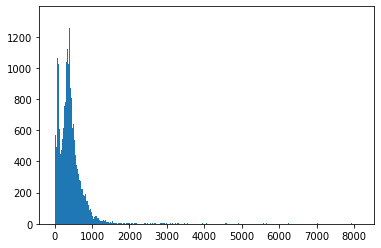

In [75]:
plt.hist([len(i) for i in X],bins=700)
plt.show()

In [76]:
# To find length of news articles greater than 1000 words
nos= np.array([len(i) for i in X])
nos[nos> 1000]

array([1110, 1300, 1108, ..., 1309, 1166, 4178])

In [77]:
len(nos[nos> 1000])


1581

1581 News artilces have greater than 1000 words

In [79]:
# Padding: To maintain equal length in all sequence of row
seqlen =1000
X= pad_sequences(X,maxlen= seqlen)

In [81]:
len(x[10])

1000

In [87]:
vocab_size=len(tokenizer.word_index)+1
vocab =  tokenizer.word_index

In [88]:
# Weight intialisation 

def get_weight_matrix(model):
  weight_matrix= np.zeros((vocab_size,Dim))

  for word, i in vocab.items():
    weight_matrix[i]= model.wv[word]

  return weight_matrix


In [89]:
get_weight_matrix(w2v_model)

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 2.02144217e+00,  7.12492228e-01, -4.63790059e-01, ...,
        -5.29724538e-01, -3.83903265e+00, -1.71266294e+00],
       [-3.25064033e-01,  2.23702788e-01, -1.29503950e-01, ...,
        -2.60923600e+00, -5.46261072e-02, -1.10078305e-02],
       ...,
       [-2.58089937e-02, -8.88207927e-03, -3.44191352e-03, ...,
        -2.34999955e-02,  1.92764811e-02,  1.95912179e-02],
       [ 3.13493120e-03,  4.10307199e-02,  2.83375904e-02, ...,
         2.01343745e-03,  1.30694788e-02,  3.26750316e-02],
       [ 1.98649913e-02,  4.16906812e-04, -6.77730236e-03, ...,
        -1.40249711e-02,  2.90742889e-02, -8.02192371e-03]])

In [93]:
embedding_vextors = get_weight_matrix(w2v_model)

In [94]:
embedding_vextors.shape

(231873, 100)

In [97]:
# Sequential Model

model= Sequential()
model.add(Embedding(vocab_size,output_dim=Dim,weights= [embedding_vextors],input_length= seqlen,trainable= False))
model.add(LSTM(units=128))
model.add(Dense(1,activation= 'sigmoid'))
model.compile(optimizer= 'adam',  loss= 'binary_crossentropy' , metrics=['acc'])

In [98]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1000, 100)         23187300  
_________________________________________________________________
lstm (LSTM)                  (None, 128)               117248    
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 23,304,677
Trainable params: 117,377
Non-trainable params: 23,187,300
_________________________________________________________________


In [100]:
X_train, X_test, y_train,y_test= train_test_split(X,y)

In [102]:
model.fit(X_train,y_train,validation_split=0.3, epochs =6)

Epoch 1/6
737/737 [==============================] - 130s 167ms/step - loss: 0.1545 - acc: 0.9435 - val_loss: 0.1218 - val_acc: 0.9590
Epoch 2/6
737/737 [==============================] - 122s 166ms/step - loss: 0.0717 - acc: 0.9765 - val_loss: 0.0769 - val_acc: 0.9748
Epoch 3/6
737/737 [==============================] - 123s 167ms/step - loss: 0.0461 - acc: 0.9853 - val_loss: 0.0491 - val_acc: 0.9855
Epoch 4/6
737/737 [==============================] - 123s 167ms/step - loss: 0.0319 - acc: 0.9906 - val_loss: 0.0399 - val_acc: 0.9874
Epoch 5/6
737/737 [==============================] - 123s 167ms/step - loss: 0.0166 - acc: 0.9948 - val_loss: 0.0399 - val_acc: 0.9884
Epoch 6/6
737/737 [==============================] - 123s 167ms/step - loss: 0.0098 - acc: 0.9966 - val_loss: 0.0333 - val_acc: 0.9891


In [106]:
y_pred= (model.predict(X_test)>0.5 ).astype(int)
y_pred

array([[1],
       [0],
       [1],
       ...,
       [1],
       [1],
       [0]])

In [105]:
accuracy_score(y_test,y_pred)

0.9923385300668152

In [107]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      5876
           1       0.99      0.99      0.99      5349

    accuracy                           0.99     11225
   macro avg       0.99      0.99      0.99     11225
weighted avg       0.99      0.99      0.99     11225



Model got trained well with 99% F1 score & accuracy

In [108]:
# Test model
z = ['This is a BBC News']
z= tokenizer.texts_to_sequences(z)
z= pad_sequences(z,maxlen= seqlen)

In [109]:
(model.predict(z)>= 0.5).astype(int)

array([[0]])

# Fake News detected

In [110]:
z= ['Joe Biden and his wife Jill travelled to the Berkshire royal residence on Marine One on Sunday after attending the G7 summit in Cornwall.The couple landed in the grounds just before 5pm, a few minutes ahead of schedule, and were greeted by the Queen in the castle’s quadrangle.A Guard of Honour formed of The Queen’s Company First Battalion Grenadier Guards gave a royal salute and the US national anthem was played beneath blue skies and hot sunshine']
z= tokenizer.texts_to_sequences(z)
z= pad_sequences(z,maxlen= seqlen)

In [111]:
(model.predict(z)>= 0.5).astype(int)

array([[1]])

Real News is detected